# Effects of borrowers' financial background on their APR
## by Meng Wang

## Investigation Overview

> In this investigation, I wanted to look at the financial background of borrowers that could be used to predict their APR. The main focus was on the five variables: income range, available bank card credit, monthly loan payment, bank card utilization and loan term.


## Dataset Overview

> The data consisted of APR and attributes related to loans during 2007-2014 of approximately 110,000 loans and 81 variables including term, date, APR and information about the borrowers such as income range and available bank card credit when open the current loan. We'll pick up around 10 variables to do further analysis and see what's affecting borrower APR. The data that BankCardUtilization is more than 1 has been removed.

In [73]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [74]:
# load in the dataset into a pandas dataframe
loan=pd.read_csv('prosperLoanData.csv')

# convert LoanStatus and IncomeRange into ordered categorical types
ordinal_var_dict = {'LoanStatus': ['Completed','FinalPaymentInProgress','Past Due (1-15 days)','Past Due (16-30 days)',
                                   'Past Due (31-60 days)','Past Due (61-90 days)','Past Due (91-120 days)',
                                  'Past Due (>120 days)','Defaulted','Chargedoff','Cancelled'],
                    'IncomeRange': ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$25,000-49,999', 
                                    '$1-24,999', '$0', 'Not employed','Not displayed'],
                   'Term':[12,36,60]}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    loan[var] = loan[var].astype(ordered_var)

## Distribution of Borrower APR

> The BorrowerAPR distribution looks bimodal,with the first peak 0.1-0.2 and second peak(even more) 0.3-0.4. Most of the loan APRs are in 0.1-0.3, but the second peak is an exception and need more attention.

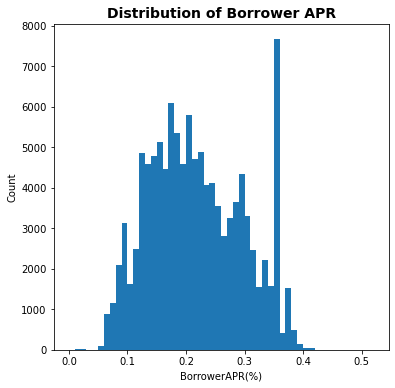

In [75]:
binsize=0.01
bins=np.arange(0,max(loan.BorrowerAPR)+binsize,binsize)
plt.figure(figsize=[6,6])
plt.hist(data=loan,x='BorrowerAPR',bins=bins)
plt.xlabel('BorrowerAPR(%)')
plt.ylabel('Count')
plt.title('Distribution of Borrower APR',fontsize=14,weight='bold')
plt.show()

## BorrowerAPR by LoanStatus, IncomeRange and Term

> Clearly, `IncomeRange` seems to be most relevant to the `BorrowerAPR`, with lower income, the APR goes up except when income range is $'0'$. There may be some input error for the $'0'$ as it equals to $'not$ $employed'$. So this exception won't change our conclusion. Term has little effect on the APR. High APR loans are usually easier to be 'past due', which means APR can represent risk level.

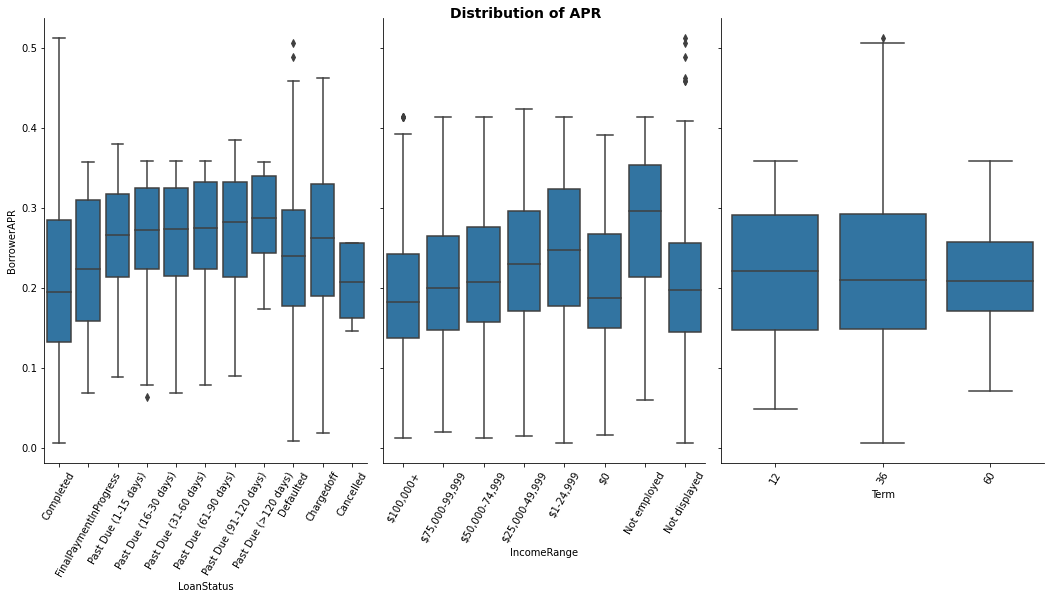

In [76]:
numeric_vars = ['BorrowerAPR', 'DebtToIncomeRatio', 'MonthlyLoanPayment', 'CurrentCreditLines', 'OpenRevolvingMonthlyPayment',
                'RevolvingCreditBalance', 'BankcardUtilization','InquiriesLast6Months','TotalInquiries','DelinquenciesLast7Years',
               'AvailableBankcardCredit']
categoric_vars = ['LoanStatus', 'IncomeRange', 'Term']
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)
    plt.xticks(rotation=60)
    


g = sb.PairGrid(data = loan, y_vars = ['BorrowerAPR'], x_vars = categoric_vars,
                height=8.27/1,aspect = (14.7/3)/(8.27/1));
g.map(boxgrid);

plt.suptitle('Distribution of APR',y=1,fontsize=14,weight='bold')
plt.tight_layout()

plt.show();

## Montly Loan Payment by Income Range

There's a declining trend of MonthlyLoanPayment when the income declines, but not very significant.

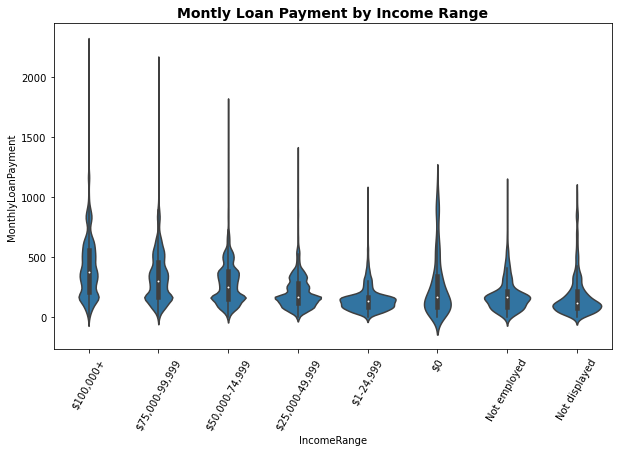

In [77]:
plt.figure(figsize=[10,6]);
default_color = sb.color_palette()[0];
sb.violinplot(data = loan, x = 'IncomeRange', y = 'MonthlyLoanPayment',
               color = default_color);
plt.xticks(rotation=60);
plt.title('Montly Loan Payment by Income Range',fontsize=14,weight='bold');

        


## Available Bank Card Credit by Income Range

There's a declining trend of available bank card credit when the income declines, but not very significant.

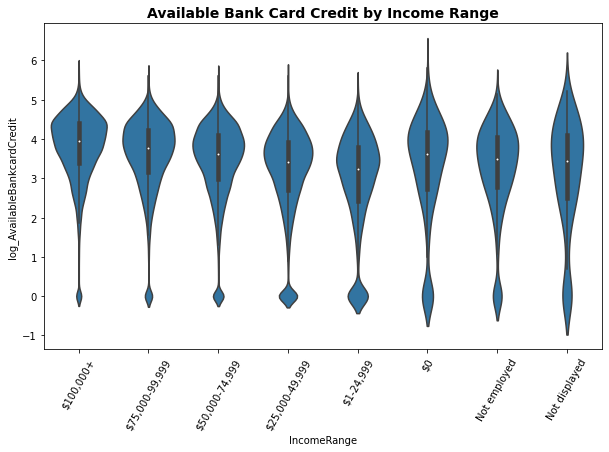

In [78]:
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x+1)
    else:
        return np.power(10, x+1)

loan['log_AvailableBankcardCredit'] = loan['AvailableBankcardCredit'].apply(log_trans)
plt.figure(figsize=[10,6])
sb.violinplot(data = loan, x = 'IncomeRange',y='log_AvailableBankcardCredit',
               color = default_color)
plt.xticks(rotation=60)
plt.title('Available Bank Card Credit by Income Range',fontsize=14,weight='bold')
    
plt.show()

## Relationship among Income Range, Available Bank Card Credit and Monthly Loan Payment

Looks like high income people usually have high monthly loan payment. It can explain why income range didn't affect the APR when available bank card credit is the same. If a hoursehold has a high income but high monthly loan payment, the bank won't give it a very low APR.

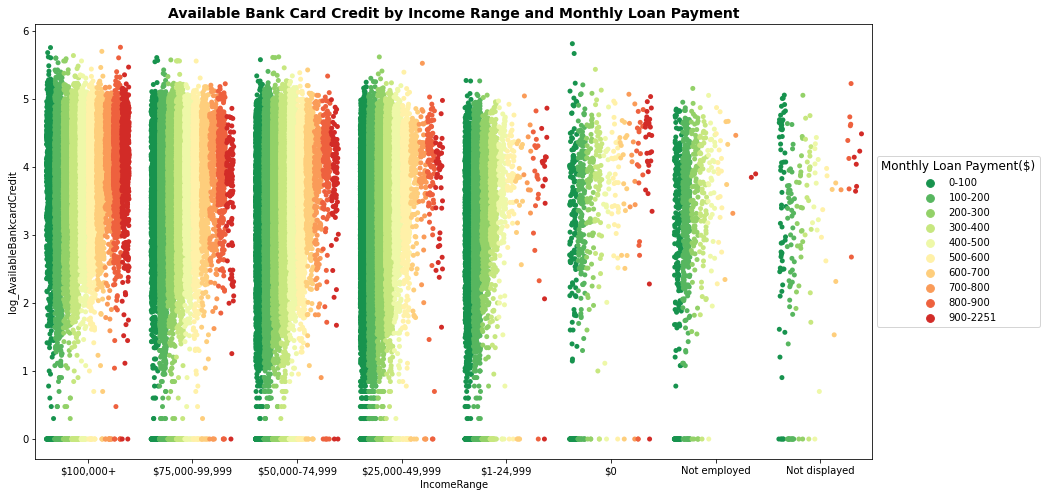

In [79]:
bins=list(np.arange(min(loan['MonthlyLoanPayment']),loan['MonthlyLoanPayment'].quantile(0.99)+100,100))+[max(loan['MonthlyLoanPayment'])]
bins=[int(x) for x in bins]
labels=[f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]


loan['MonthlyLoanPayment_c']=pd.cut(loan['MonthlyLoanPayment'],bins=bins,labels=labels,right=False)
plt.figure(figsize=[15,8]);
sb.stripplot(data=loan,x='IncomeRange',y='log_AvailableBankcardCredit',hue='MonthlyLoanPayment_c',jitter=0.35,dodge=True,
             palette='RdYlGn_r');
plt.title('Available Bank Card Credit by Income Range and Monthly Loan Payment',fontsize=14,weight='bold')
plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title='Monthly Loan Payment($)',title_fontsize=12);



## APR by IncomeRange and Term
In terms of high income range, the BorrowerAPR didn't change much across different terms. But for low income range, shorter term tend to have higher APR.

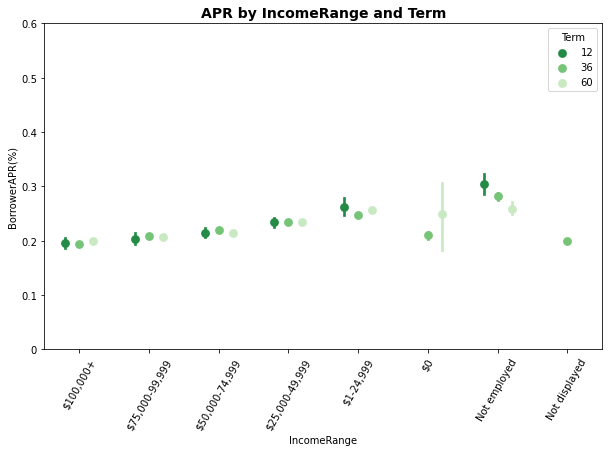

In [80]:
fig = plt.figure(figsize = [10,6])
ax = sb.pointplot(data = loan, x = 'IncomeRange', y = 'BorrowerAPR', hue = 'Term',
           palette = 'Greens_r', linestyles = '', dodge = 0.4)
plt.title('APR by IncomeRange and Term',fontsize=14,weight='bold')
plt.ylabel('BorrowerAPR(%)')

plt.yticks(np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6]), [0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6])
ax.set_yticklabels([],minor = True)
plt.xticks(rotation=60)
plt.show();

In [81]:
!jupyter nbconvert slide_deck_Loan.ipynb --to slides --post serve  --no-input --no-prompt 

[NbConvertApp] Converting notebook slide_deck_Loan.ipynb to slides
[NbConvertApp] Writing 788663 bytes to slide_deck_Loan.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/slide_deck_Loan.slides.html
Use Control-C to stop this server
^C

Interrupted
